In [1]:
from dataclasses import dataclass
from functools import partial
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
K = 120       # Strike
T = 1         # Maturity (years)
sig = 0.2     # Volatility
r = 0.05      # Risk-free rate

In [3]:
@dataclass
class BSOutput:
    price: float
    delta: float
    gamma: float
        

def black_scholes(S0, K, T, r, sig, option_type):
    assert option_type in ('call', 'put')
    d1 = (math.log(S0 / K) + (r + 0.5 * sig ** 2) * T) / (sig * math.sqrt(T))
    d2 = d1 - sig * math.sqrt(T)
    c = S0 * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    p = -S0 * norm.cdf(-d1) + K * math.exp(-r * T) * norm.cdf(-d2)
    delta_c = norm.cdf(d1)
    delta_p = delta_c - 1
    gamma = norm.pdf(d1) / (S0 * sig * math.sqrt(T))
    return BSOutput(c, delta_c, gamma) if option_type == 'call' else BSOutput(p, delta_p, gamma)

# Plotting the greeks

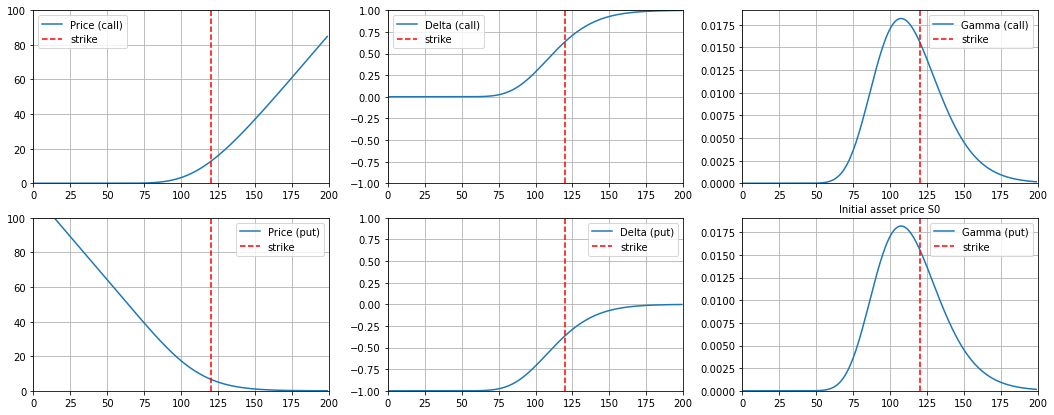

In [4]:
S0s = list(range(1, 200))
bsc = [black_scholes(S0, K, T, r, sig, 'call') for S0 in S0s]
bsp = [black_scholes(S0, K, T, r, sig, 'put') for S0 in S0s]

fig, axes = plt.subplots(2, 3, figsize=(18, 7))

axes[0, 0].plot(S0s, [x.price for x in bsc], label='Price (call)')
axes[1, 0].plot(S0s, [x.price for x in bsp], label='Price (put)')
axes[0, 0].set_ylim(0, 100)
axes[1, 0].set_ylim(0, 100)

axes[0, 1].plot(S0s, [x.delta for x in bsc], label='Delta (call)')
axes[1, 1].plot(S0s, [x.delta for x in bsp], label='Delta (put)')
axes[0, 1].set_ylim(-1, 1)
axes[1, 1].set_ylim(-1, 1)

axes[0, 2].plot(S0s, [x.gamma for x in bsc], label='Gamma (call)')
axes[1, 2].plot(S0s, [x.gamma for x in bsc], label='Gamma (put)')
axes[0, 2].set_ylim(bottom=0)
axes[1, 2].set_ylim(bottom=0)

axes[0, 2].set(xlabel='Initial asset price S0')
for ax in axes.ravel():
    ax.axvline(x=K, color='red', linestyle='--', label='strike')
    ax.set_xlim(0, 200)
    ax.grid('on')
    ax.legend()
    
plt.show()

# Hedging a short call

In [5]:
def profit_(num_options: int, coverage_level: float, S0: float, S1: float, price_0: float, price_1: float):
    return num_options * coverage_level * (S1 - S0) - num_options * (price_1 - price_0)

In [6]:
num_options = 1000
S0 = 100
bs0 = black_scholes(S0, K, T, r, sig, 'call')

for S1 in [95, 99, 101, 105]:
    bs1 = black_scholes(S1, K, T, r, sig, 'call')
    profit = partial(profit_, num_options=num_options, S0=S0, S1=S1, price_0=bs0.price, price_1=bs1.price)
    print('\n------------------------------')
    print(f'New price = {S1}\n')
    print(f'Naked         : {profit(coverage_level=0):.2f}')
    print(f'Covered       : {profit(coverage_level=1):.2f}')
    print(f'Delta-neutral : {profit(coverage_level=bs0.delta):.2f}')


------------------------------
New price = 95

Naked         : 1230.42
Covered       : -3769.58
Delta-neutral : -205.53

------------------------------
New price = 99

Naked         : 278.73
Covered       : -721.27
Delta-neutral : -8.47

------------------------------
New price = 101

Naked         : -295.76
Covered       : 704.24
Delta-neutral : -8.57

------------------------------
New price = 105

Naked         : -1654.27
Covered       : 3345.73
Delta-neutral : -218.31


# Hedging a short put

In [7]:
num_options = 1000
S0 = 100
bs0 = black_scholes(S0, K, T, r, sig, 'put')

for S1 in [95, 99, 101, 105]:
    bs1 = black_scholes(S1, K, T, r, sig, 'put')
    profit = partial(profit_, num_options=num_options, S0=S0, S1=S1, price_0=bs0.price, price_1=bs1.price)
    print('\n------------------------------')
    print(f'New price = {S1}\n')
    print(f'Naked         : {profit(coverage_level=0):.2f}')
    print(f'Covered       : {profit(coverage_level=-1):.2f}')
    print(f'Delta-neutral : {profit(coverage_level=bs0.delta):.2f}')


------------------------------
New price = 95

Naked         : -3769.58
Covered       : 1230.42
Delta-neutral : -205.53

------------------------------
New price = 99

Naked         : -721.27
Covered       : 278.73
Delta-neutral : -8.47

------------------------------
New price = 101

Naked         : 704.24
Covered       : -295.76
Delta-neutral : -8.57

------------------------------
New price = 105

Naked         : 3345.73
Covered       : -1654.27
Delta-neutral : -218.31
